# AI Search with RAG optimization
This document illustrates an example workflow for how to optimize Azure AI Search for RAG use cases to enhance the quality of document search. 

# Objective
See if your RAG app's quality metrics improve using only the capabilities of Azure AI Search
- Enhanced Vector (text-embedding3-large)
- Multivector
- BM25 + Vector
- BM25 + Vector + Semantic Reranking
- BM25 + Vector + Semantic Reranking + Query Rewrite


## Prerequisites
Configure a Python virtual environment for 3.10 or later: 
 1. open the Command Palette (Ctrl+Shift+P).
 1. Search for Python: Create Environment.
 1. select Venv / Conda and choose where to create the new environment.
 1. Select the Python interpreter version. Create with version 3.10 or later.

For a dependency installation, run the code below to install the packages required to run it. 

```bash
# Create a virtual environment
python -m venv venv

# Activate the virtual environment
# On Windows
venv\Scripts\activate

# On macOS/Linux
source venv/bin/activate

pip install -r requirements.txt
```

## Set up your environment
Git clone the repository to your local machine. 

```bash
git clone https://github.com/hyogrin/Azure_OpenAI_samples.git
```

Create an .env file based on the .env-sample file. Copy the new .env file to the folder containing your notebook and update the variables.

In [2]:
import os
from azure.search.documents import SearchItemPaged
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import (
    VectorizedQuery,
    SearchScoreThreshold,
    VectorSimilarityThreshold,
    QueryType, 
    QueryAnswerType,
    QueryCaptionType,
    QueryDebugMode,
    VectorizableTextQuery
    
)
from azure.search.documents import SearchClient
from dotenv import load_dotenv

load_dotenv(override=True)   


search_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
index_name = os.getenv("AZURE_SEARCH_INDEX_NAME")
admin_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")
openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
openai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
openai_api_version = os.getenv("AZURE_OPENAI_CHAT_API_VERSION")
small3_deployment = os.getenv("AZURE_OPENAI_3_SMALL_EMBEDDING_DEPLOYMENT_NAME")
large3_deployment = os.getenv("AZURE_OPENAI_3_LARGE_EMBEDDING_DEPLOYMENT_NAME")
gpt_chat_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
ai_project_conn_str = os.getenv("AZURE_AI_PROJECT_CONN_STR")

QUERIES_FILE = "data/rag_sample_qna_ko.jsonl"

print(f"search_endpoint: {search_endpoint}")

search_endpoint: https://rag-innovator-search-svc.search.windows.net


In [3]:

def print_results(results: SearchItemPaged[dict]):
    semantic_answers = results.get_answers()
    if semantic_answers:
        for answer in semantic_answers:
            if answer.highlights:
                print(f"Semantic Answer: {answer.highlights}")
            else:
                print(f"Semantic Answer: {answer.text}")
            print(f"Semantic Answer Score: {answer.score}\n")

    for result in results:
        # print(f"Title: {result['title']}")  
        print(f"Score: {result['@search.score']}")
        if result.get('@search.reranker_score'):
            print(f"Reranker Score: {result['@search.reranker_score']}")
        print(f"Content: {result['content']}")  
        # print(f"Category: {result['new_product_name']}\n")

        captions = result["@search.captions"]
        if captions:
            caption = captions[0]
            if caption.highlights:
                print(f"Caption: {caption.highlights}\n")
            else:
                print(f"Caption: {caption.text}\n")
        print("-" * 200)

In [4]:
embed_client = AzureOpenAI(
    azure_deployment=small3_deployment,
    api_version="2023-05-15",
    azure_endpoint=openai_endpoint,
    api_key=openai_api_key,
)

embed3_client = AzureOpenAI(
    azure_deployment=large3_deployment,
    api_version="2023-05-15",
    azure_endpoint=openai_endpoint,
    api_key=openai_api_key,
)

search_client = SearchClient(endpoint=search_endpoint, index_name=index_name, credential=AzureKeyCredential(admin_key))

with open('main_prompt_plain.txt', 'r') as file:
    prompt_template = file.read()

## SEMANTIC, HYBRID, RERANKER, REWRITE Search 

In [12]:
from enum import Enum

class SearchType(Enum):   
    SEMANTIC = "semantic"
    HYBRID = "hybrid"
    SEMANTIC_WITH_RERANKER = "semantic_with_reranker"
    HYBRID_WITH_RERANKER = "hybrid_with_reranker"
    SEMANTIC_WITH_RERANKER_REWRITE = "semantic_with_reranker_rewrite"
    HYBRID_WITH_RERANKER_REWRITE = "hybrid_with_reranker_rewrite"
    

def search_with_type(search_type, embedding, category, type, query_text=None, vector_field="content_vector", similarity_threshold=None):
    results = None
    vector_query = VectorizedQuery(vector=embedding, k_nearest_neighbors=50, fields=vector_field, threshold=similarity_threshold
                                )
    if search_type == SearchType.SEMANTIC:
        results = search_client.search(
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            top=3
        )
    elif search_type == SearchType.HYBRID:
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            top=3
        )
    elif search_type == SearchType.HYBRID_WITH_RERANKER:        
        results = search_client.search(
            search_text=query_text,
            # search_text=None, # use No-BM25 search
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            query_type=QueryType.SEMANTIC,
            semantic_configuration_name="my-semantic-config",
            # https://learn.microsoft.com/en-us/azure/search/semantic-how-to-query-rewrite
            query_language="ko-KR",
            query_caption=QueryCaptionType.EXTRACTIVE,
            query_answer=QueryAnswerType.EXTRACTIVE,    
            top=3
        )
    elif search_type == SearchType.HYBRID_WITH_RERANKER_REWRITE:
        results = search_client.search(
            # search_text=query_text,
            # Semantic search query rewrite is not available for this service.
            vector_queries=[vector_query],
            filter=f"category eq '{category}' and type eq '{type}'" if category and type else None,
            query_type=QueryType.SEMANTIC,
            semantic_configuration_name="my-semantic-config",
            # https://learn.microsoft.com/en-us/azure/search/semantic-how-to-query-rewrite
            query_language="ko-KR",
            query_rewrites="generative|count-5",
            debug=QueryDebugMode.QUERY_REWRITES,
            query_caption=QueryCaptionType.EXTRACTIVE,
            query_answer=QueryAnswerType.EXTRACTIVE,    
            top=3
            
    )
    return results
    return results

In [13]:
import json

def save_search_result(search_type, embedding_model, search_result_file_name, line_num, similarity_threshold=None):
    def get_embedding(query):
        return embed_client.embeddings.create(input=[query], model=embedding_model).data[0].embedding

    query_document = []

    with open(QUERIES_FILE, 'r') as f:
        for i, line in enumerate(f):
            # initialize the list to store documents for each query
            documents = []
            if i >= line_num:  # Limit to processing questions
                break
            query = json.loads(line.strip())  # Parse each line as a JSON object
            embedding = get_embedding(query['question'])
            category = query['category']
            type = query['type']
            results = search_with_type(search_type, embedding, category, type, query['question'], vector_field="content_vector", similarity_threshold=similarity_threshold) 
            #print_results(results)
            
            for res in results:
                documents.append(res['content'])
            
            if len(documents) > 0:
                document_content = "\n".join(documents)
            else:
                document_content = "No documents found."
            query_document.append({"query": query['question'], "document_content": document_content})
    
    with open(f'{search_result_file_name}', 'w') as outfile:
        json.dump(query_document, outfile, ensure_ascii=False, indent=4)

## Save the search results for each search method

In [14]:
NUMBER_OF_QUESTIONS = 10
#similarity_threshold = VectorSimilarityThreshold(value=0.78)
similarity_threshold = None

In [15]:
# [small3] SEMANTIC Search
print("=== [small3] SEMANTIC Search ===")
save_search_result(SearchType.SEMANTIC, small3_deployment, 'result_search/queries_contexts_small3_semantic.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [small3] HYBRID Search
print("=== [small3] HYBRID Search ===")
save_search_result(SearchType.HYBRID, small3_deployment, 'result_search/queries_contexts_small3_hybrid.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [large3] HYBRID Search
print("=== [large3] HYBRID Search ===")
save_search_result(SearchType.HYBRID, large3_deployment, 'result_search/queries_contexts_large3_hybrid.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [large3] HYBRID + RERANKER Search
print("=== [large3] HYBRID + RERANKER Search ===")
save_search_result(SearchType.HYBRID_WITH_RERANKER, large3_deployment, 'result_search/queries_contexts_large3_hybrid_reranker.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

# [large3] HYBRID + RERANKER + REWRITE Search
print("=== [large3] HYBRID + RERANKER + REWRITE Search ===")
save_search_result(SearchType.HYBRID_WITH_RERANKER_REWRITE, large3_deployment, 'result_search/queries_contexts_large3_hybrid_reranker_rewrite.json', NUMBER_OF_QUESTIONS, similarity_threshold=similarity_threshold)

## Get answer with RAG orchestrator

In [16]:
def save_response_use_llm(search_result_file_name, response_file_name):
    def process_llm(query, document_content):
        openai_client = AzureOpenAI(
        azure_deployment=gpt_chat_deployment,
        api_version=openai_api_version,
        azure_endpoint=openai_endpoint,
        api_key=openai_api_key,
    )

        prompt = prompt_template.replace("{question}", query)
        prompt = prompt.replace("{document}", document_content)
        response = openai_client.chat.completions.create(
        model=gpt_chat_deployment,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )

        answer = response.choices[0].message.content.strip()
        return answer

    with open(f'{search_result_file_name}', 'r') as f:
        queries_document = json.load(f)

    query_answers_contexts = []

    for query_doc in queries_document:
        query = query_doc['query']
        document_content = query_doc['document_content']
        answer = process_llm(query, document_content) 
    # print(f"Query: {query}\nAnswer: {answer}\n")

        query_answers_contexts.append({
        "query": query,
        "document_content": document_content,
        "answer": answer
    })

    with open(f'{response_file_name}', 'w') as outfile:
        for item in query_answers_contexts:
            json.dump(item, outfile, ensure_ascii=False)
            outfile.write('\n')


In [ ]:
# [small3] SEMANTIC Search
print("=== [small3] SEMANTIC Search ===")
save_response_use_llm('result_search/queries_contexts_small3_semantic.json', 'result_response/queries_responses_small3_semantic.jsonl')

# [small3] HYBRID Search
print("=== [small3] HYBRID Search ===")
save_response_use_llm('result_search/queries_contexts_small3_hybrid.json', 'result_response/queries_responses_small3_hybrid.jsonl')

# [large3] HYBRID Search
print("=== [large3] HYBRID Search ===")
save_response_use_llm('result_search/queries_contexts_large3_hybrid.json', 'result_response/queries_responses_large3_hybrid.jsonl')

# [large3] HYBRID + RERANKER Search
print("=== [large3] HYBRID + RERANKER Search ===")
save_response_use_llm('result_search/queries_contexts_large3_hybrid_reranker.json', 'result_response/queries_responses_large3_hybrid_reranker.jsonl')

# [large3] HYBRID + RERANKER + REWRITE Search
print("=== [large3] HYBRID + RERANKER + REWRITE Search ===")
save_response_use_llm('result_search/queries_contexts_large3_hybrid_reranker_rewrite.json', 'result_response/queries_responses_large3_hybrid_reranker_rewrite.jsonl')

## Evaluate by Azure AI Evaluator

In [18]:
import os
from datetime import datetime
from azure.ai.evaluation import (
    evaluate, 
    FluencyEvaluator, 
    GroundednessEvaluator, 
    RelevanceEvaluator, 
    CoherenceEvaluator,
    SimilarityEvaluator,
    RetrievalEvaluator

)

column_mapping = {
    "query": "${data.query}",
    "context": "${data.document_content}",
    "response": "${data.answer}"
}


model_config = {
    "azure_endpoint": openai_endpoint,
    "api_key": openai_api_key,
    "azure_deployment": gpt_chat_deployment,
    "api_version": openai_api_version,
}


retrievalEvaluator = RetrievalEvaluator(model_config)
fluencyEvaluator = FluencyEvaluator(model_config)
groundednessEvaluator = GroundednessEvaluator(model_config)
relevanceEvaluator = RelevanceEvaluator(model_config)
coherenceEvaluator = CoherenceEvaluator(model_config)
similarityEvaluator = SimilarityEvaluator(model_config)

azure_ai_project_conn_str = os.environ.get("AZURE_AI_PROJECT_CONN_STR")
subscription_id = azure_ai_project_conn_str.split(";")[1]
resource_group_name = azure_ai_project_conn_str.split(";")[2]
project_name = azure_ai_project_conn_str.split(";")[3]

azure_ai_project = {
    "subscription_id": subscription_id,
    "resource_group_name": resource_group_name,
    "project_name": project_name,
}

In [19]:
def azure_evaluator(eval_name, response_file_name, eval_output_file_name):
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M")
    
    result = evaluate(
    evaluation_name=f"rag_opt_{eval_name}_{current_time}",
    data=f"{response_file_name}",
    evaluators={
        # "fluency": fluencyEvaluator,
        # "groundedness": groundednessEvaluator,
        "retrieval": retrievalEvaluator,
        "relevance": relevanceEvaluator,
        # "coherence": coherenceEvaluator,
        # "similarity": similarityEvaluator,
    },
    evaluator_config={
        "retrieval": {"column_mapping": column_mapping},
        # "fluency": {
        #     "column_mapping": column_mapping
        # },
        # "groundedness": {
        #     "column_mapping": column_mapping
        # },
        "relevance": {
            "column_mapping": column_mapping
        },
        # "coherence": {
        #     "column_mapping": column_mapping
        # },
        # "similarity": {
        #     "column_mapping": column_mapping
        # }
    },
    #azure_ai_project=azure_ai_project,
    # for upload the result into the Azure AI project, please uncomment the above line
    # if you run into an issue of the permission, check the link https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/evaluation/azure-ai-evaluation/TROUBLESHOOTING.md
    output_path=eval_output_file_name
    )
    return result


In [21]:
# [small3] SEMANTIC Search
print("=== [small3] SEMANTIC Search ===")
azure_evaluator('small3_semantic', 'result_response/queries_responses_small3_semantic.jsonl', 'result_eval/eval_small3_semantic.json')

# [small3] HYBRID Search
print("=== [small3] HYBRID Search ===")
azure_evaluator('small3_hybrid', 'result_response/queries_responses_small3_hybrid.jsonl', 'result_eval/eval_small3_hybrid.json')

# [large3] HYBRID Search
print("=== [large3] HYBRID Search ===")
azure_evaluator('large3_hybrid', 'result_response/queries_responses_large3_hybrid.jsonl', 'result_eval/eval_large3_hybrid.json')

# [large3] HYBRID + RERANKER Search
print("=== [large3] HYBRID + RERANKER Search ===")
azure_evaluator('large3_hybrid_reranker', 'result_response/queries_responses_large3_hybrid_reranker.jsonl', 'result_eval/eval_large3_hybrid_reranker.json')

# [large3] HYBRID + RERANKER + REWRITE Search
print("=== [large3] HYBRID + RERANKER + REWRITE Search ===")
azure_evaluator('large3_hybrid_reranker_rewrite', 'result_response/queries_responses_large3_hybrid_reranker_rewrite.jsonl', 'result_eval/eval_hybrid_reranker_rewrite.json')

[2025-05-02 06:29:04 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:04 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:04 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_myamox9_20250502_062904_908459, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_myamox9_20250502_062904_908459/logs.txt
[2025-05-02 06:29:04 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_3hn5sctu_20250502_062904_910184, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluatio

2025-05-02 06:29:08 +0000 1202740 execution.bulk     INFO     Finished 10 / 10 lines.
2025-05-02 06:29:08 +0000 1202740 execution.bulk     INFO     Average execution time for completed lines: 0.31 seconds. Estimated time for incomplete lines: 0.0 seconds.


[2025-05-02 06:29:09 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:09 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:09 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_ug2uzg7q_20250502_062909_096866, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_ug2uzg7q_20250502_062909_096866/logs.txt
[2025-05-02 06:29:09 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_ex8sctc4_20250502_062909_095766, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluat

2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Finished 6 / 10 lines.
2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Average execution time for completed lines: 0.86 seconds. Estimated time for incomplete lines: 3.44 seconds.
2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Finished 7 / 10 lines.
2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Average execution time for completed lines: 0.74 seconds. Estimated time for incomplete lines: 2.22 seconds.
2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Finished 8 / 10 lines.
2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Average execution time for completed lines: 0.67 seconds. Estimated time for incomplete lines: 1.34 seconds.
2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Finished 9 / 10 lines.
2025-05-02 06:29:14 +0000 1202740 execution.bulk     INFO     Average execution time for completed lines: 0.64 seconds. Estimated time for incomple

[2025-05-02 06:29:16 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:16 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:16 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_0fkv84w7_20250502_062916_279743, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_0fkv84w7_20250502_062916_279743/logs.txt
[2025-05-02 06:29:16 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_v9tzwm56_20250502_062916_280652, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluat

2025-05-02 06:29:20 +0000 1202740 execution.bulk     INFO     Finished 10 / 10 lines.
2025-05-02 06:29:20 +0000 1202740 execution.bulk     INFO     Average execution time for completed lines: 0.45 seconds. Estimated time for incomplete lines: 0.0 seconds.


[2025-05-02 06:29:21 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:21 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:21 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_8hevwrox_20250502_062921_434081, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_8hevwrox_20250502_062921_434081/logs.txt
[2025-05-02 06:29:21 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_d9nlzm74_20250502_062921_433180, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluat

2025-05-02 06:29:26 +0000 1202740 execution.bulk     INFO     Finished 10 / 10 lines.
2025-05-02 06:29:26 +0000 1202740 execution.bulk     INFO     Average execution time for completed lines: 0.52 seconds. Estimated time for incomplete lines: 0.0 seconds.


[2025-05-02 06:29:27 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:27 +0000][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't take effect. Please handle timeout manually outside current process.
[2025-05-02 06:29:27 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_vf8ys3an_20250502_062927_625718, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_vf8ys3an_20250502_062927_625718/logs.txt
[2025-05-02 06:29:27 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run azure_ai_evaluation_evaluators_common_base_eval_asyncevaluatorbase_9h0ig0nf_20250502_062927_626609, log path: /home/azureuser/.promptflow/.runs/azure_ai_evaluat

{'rows': [{'inputs.query': '<갤러그 S24 시리즈>의 새로운 점과 다른 점은 무엇인가요?',
   'inputs.document_content': '스타즈의 최신 갤러그 S24 시리즈는 최신 기술을 집약한 스마트폰으로, 다양한 AI 기능을 통해 사용자 경험을 극대화합니다. 이 시리즈는 연결성, 창의성, 엔터테인먼트 측면에서 혁신적인 변화를 가져오며, 특히 AI 기반의 기능들이 돋보입니다. 갤러그 S24는 고급 카메라 시스템을 갖추고 있어, AI를 활용한 이미지 처리 기술로 더욱 선명하고 생동감 있는 사진을 촬영할 수 있습니다. 예를 들어, AI는 자동으로 최적의 촬영 모드를 선택하고, 저조도 환경에서도 뛰어난 성능을 발휘합니다. 또한, 인공지능 비서 기능이 탑재되어 있어, 음성 명령으로 다양한 작업을 수행할 수 있으며, 개인화된 추천 서비스를 통해 사용자 맞춤형 콘텐츠를 제공합니다. 연결성 측면에서도 갤러그 S24는 5G 네트워크를 지원하여 빠르고 안정적인 인터넷 속도를 제공합니다. 이를 통해 스트리밍, 게임, 화상 통화 등 다양한 온라인 활동을 원활하게 즐길 수 있습니다. 창의적인 작업을 지원하기 위해, 갤러그 S24는 다양한 생산성 도구와 앱을 제공하며, S펜과의 호환성으로 더욱 정교한 작업이 가능합니다. 사용자는 메모를 하거나 그림을 그리는 등 창의적인 작업을 손쉽게 수행할 수 있습니다. 엔터테인먼트 기능 또한 강화되어, 고해상도 디스플레이와 스테레오 스피커를 통해 몰입감 있는 시청 경험을 제공합니다. AI는 사용자의 시청 습관을 분석하여 개인 맞춤형 콘텐츠 추천을 통해 더욱 풍부한 엔터테인먼트 경험을 선사합니다. 이처럼 갤러그 S24 시리즈와 갤러그 AI는 현대인의 다양한 요구를 충족시키기 위해 설계된 혁신적인 제품입니다.\n플래그십 스마트폰의 핵심 AI 기능은 최신 기술을 통해 사용자에게 보다 스마트하고 효율적인 경험을 제공합니다. 이러한 기능들은 고급 카메라 시스템, 개인화된 음성 비서, 스마트 배터리 관리, 그리고 실시간 번

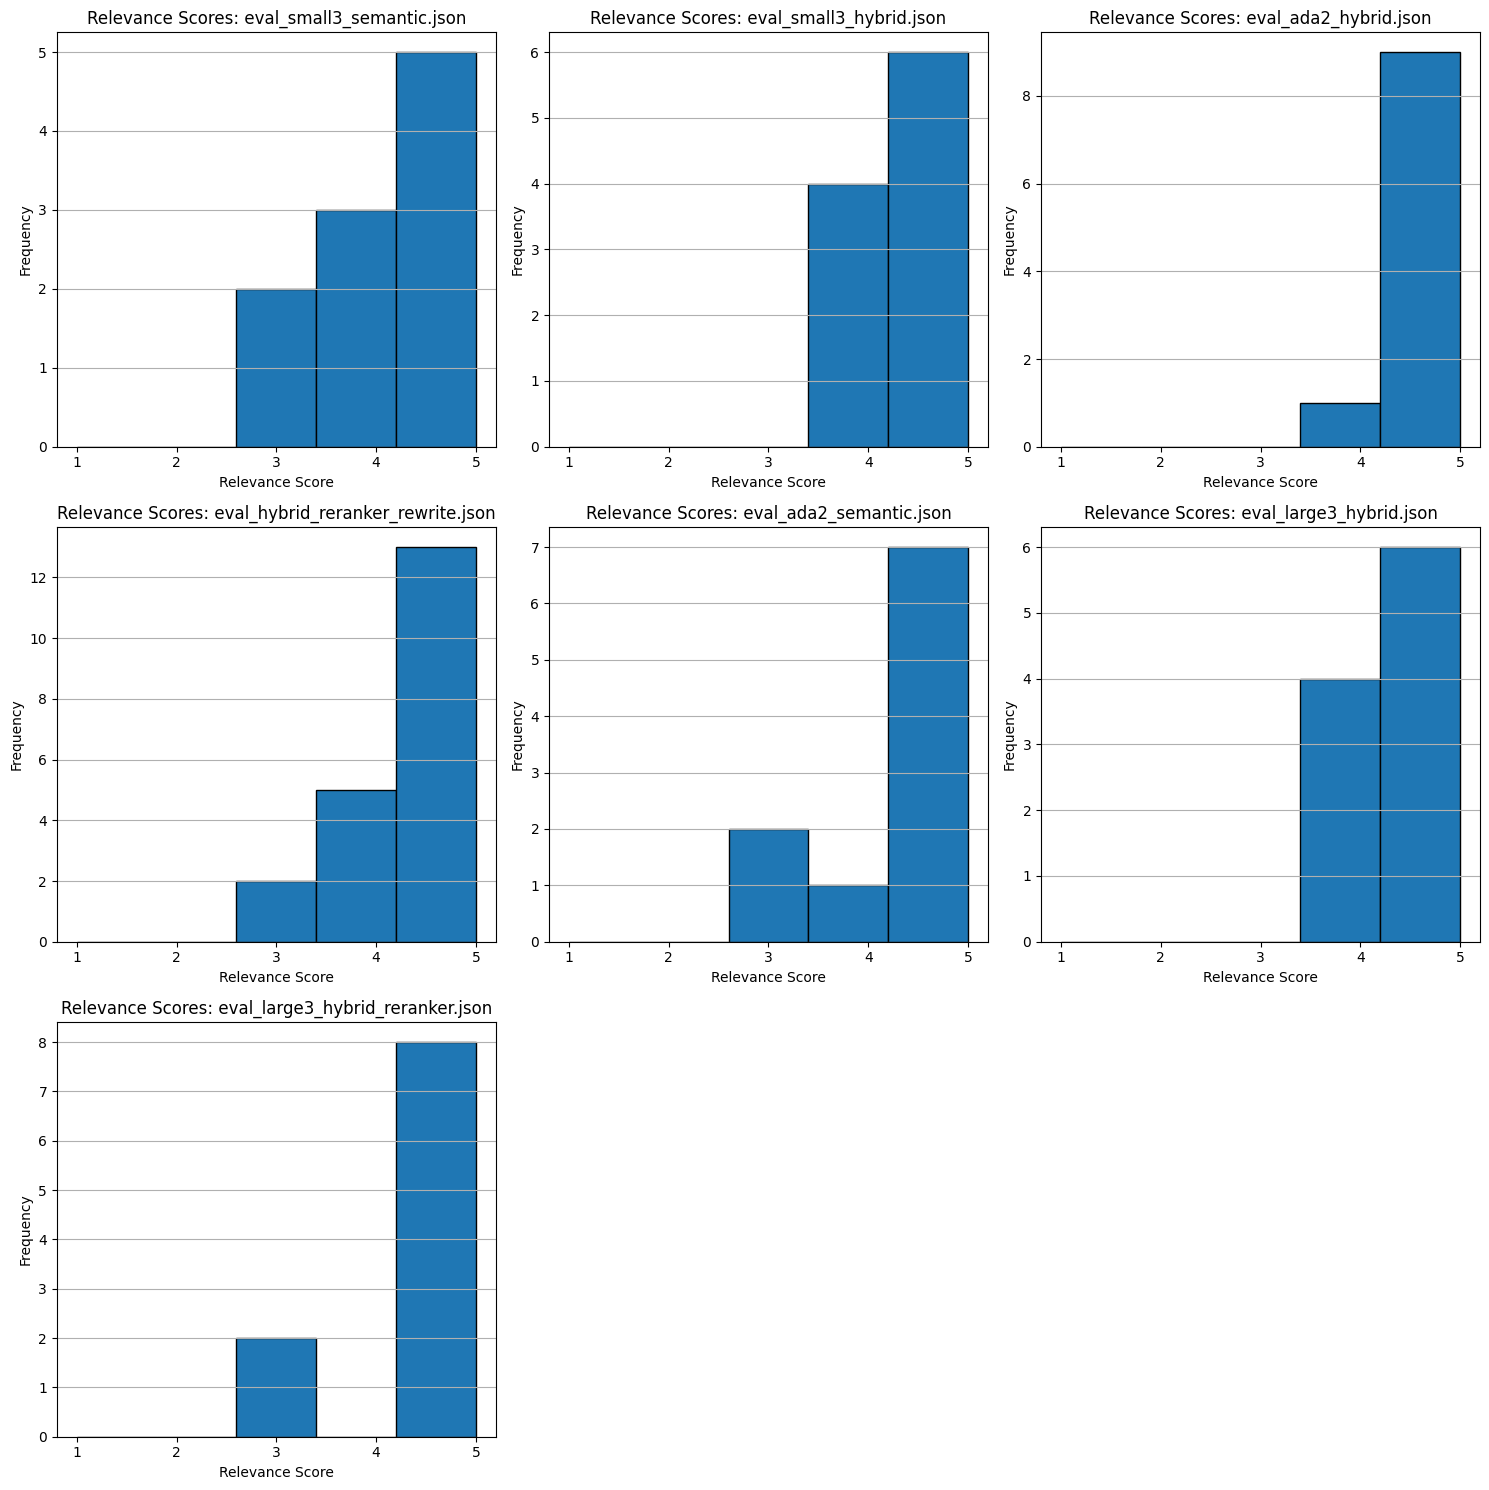

In [22]:
import json
import os
import matplotlib.pyplot as plt

# Directory containing evaluation result JSON files
eval_dir = 'result_eval'

# Get all JSON files in the directory
eval_files = [f for f in os.listdir(eval_dir) if f.endswith('.json')]

# Initialize a figure for the plots
num_files = len(eval_files)
rows = (num_files + 2) // 3  # Calculate the number of rows (3 graphs per row)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

# Loop through each file and plot the relevance scores
for i, eval_file in enumerate(eval_files):
    with open(os.path.join(eval_dir, eval_file), 'r') as f:
        evaluation_results = json.load(f)

    # Extract the relevance scores
    relevance_scores = [row['outputs.relevance.relevance'] for row in evaluation_results['rows']]

    # Plot the relevance scores
    axes[i].hist(relevance_scores, bins=5, range=(1, 5), edgecolor='black')
    axes[i].set_title(f'Relevance Scores: {eval_file}')
    axes[i].set_xlabel('Relevance Score')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(range(1, 6))
    axes[i].grid(axis='y')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

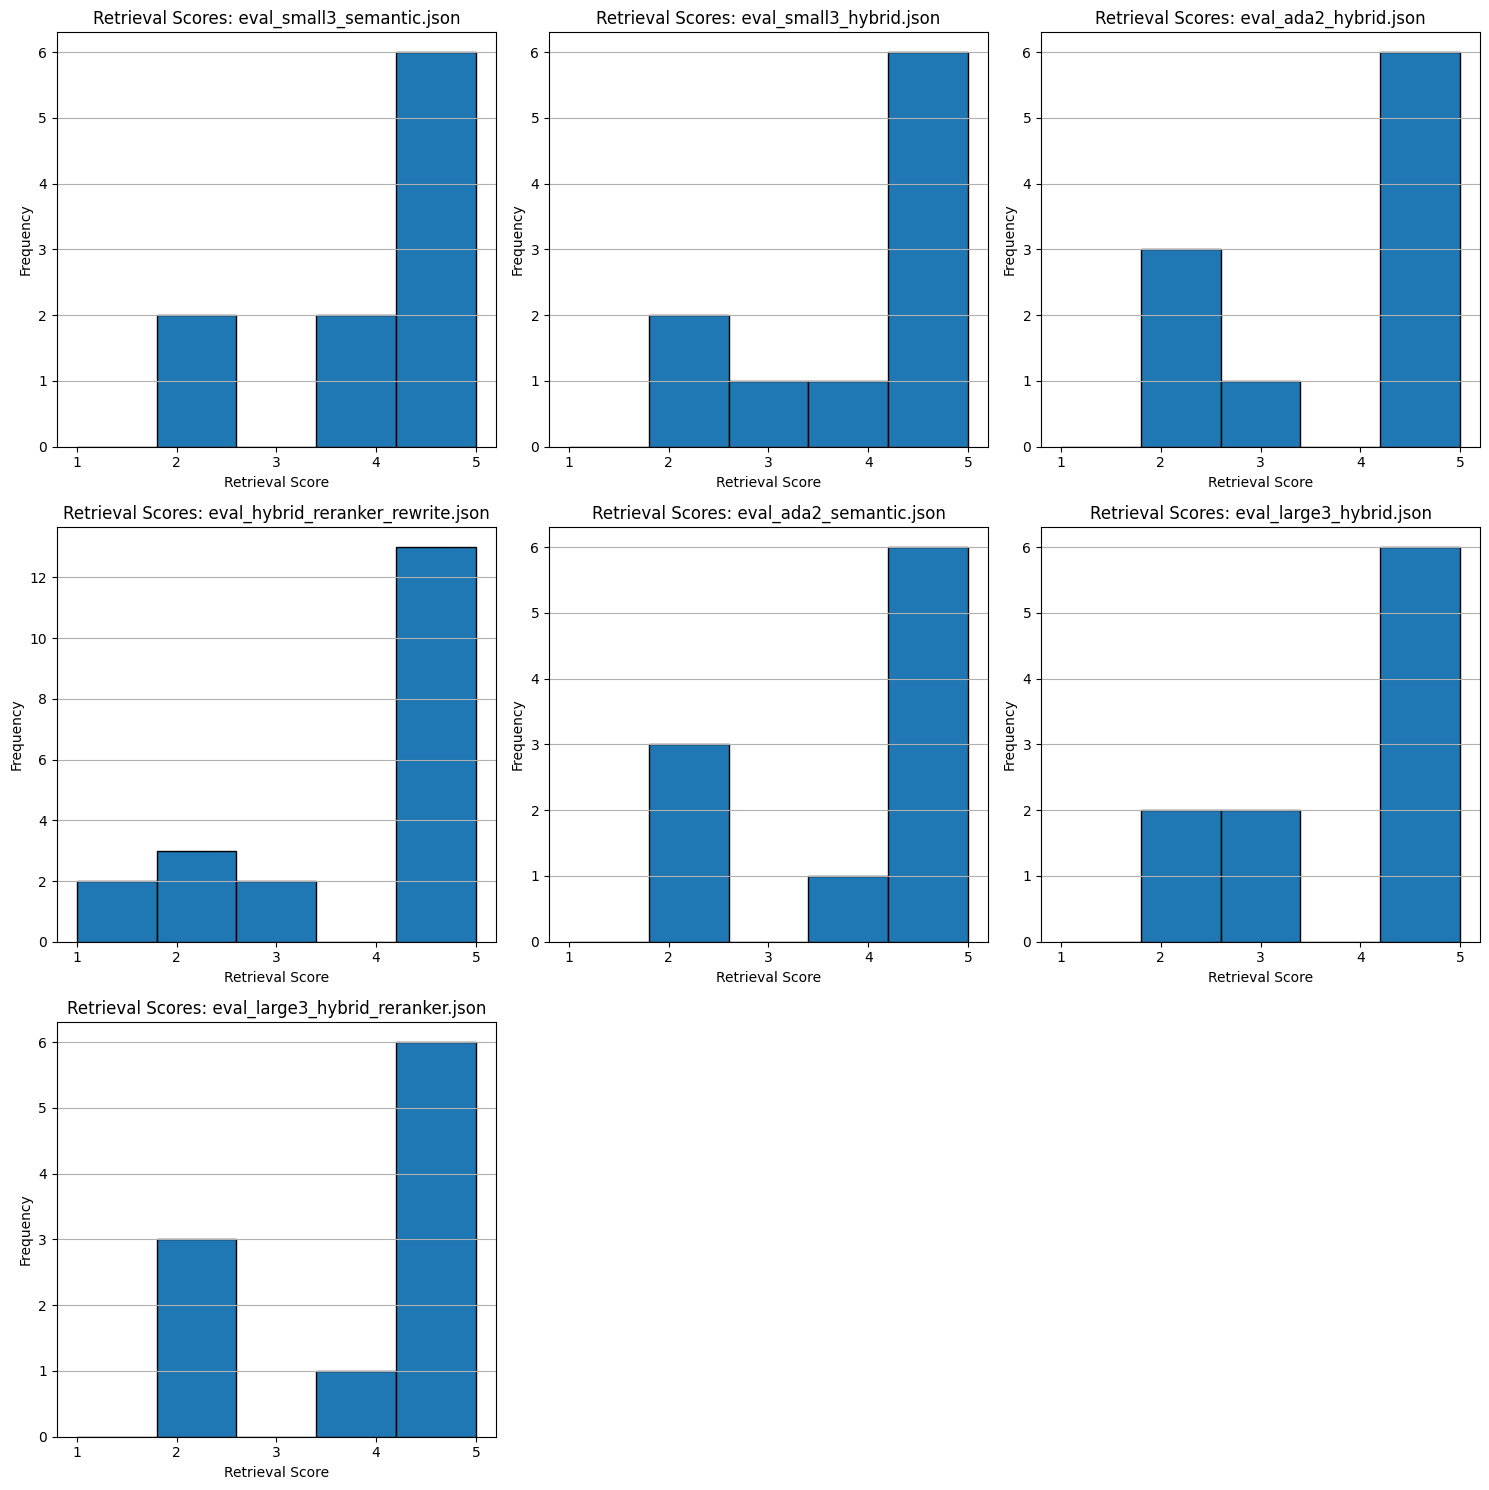

In [23]:
import json
import os
import matplotlib.pyplot as plt

# Directory containing evaluation result JSON files
eval_dir = 'result_eval'

# Get all JSON files in the directory
eval_files = [f for f in os.listdir(eval_dir) if f.endswith('.json')]

# Initialize a figure for the plots
num_files = len(eval_files)
rows = (num_files + 2) // 3  # Calculate the number of rows (3 graphs per row)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

# Loop through each file and plot the relevance scores
for i, eval_file in enumerate(eval_files):
    with open(os.path.join(eval_dir, eval_file), 'r') as f:
        evaluation_results = json.load(f)

    # Extract the relevance scores
    relevance_scores = [row['outputs.retrieval.retrieval'] for row in evaluation_results['rows']]

    # Plot the relevance scores
    axes[i].hist(relevance_scores, bins=5, range=(1, 5), edgecolor='black')
    axes[i].set_title(f'Retrieval Scores: {eval_file}')
    axes[i].set_xlabel('Retrieval Score')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(range(1, 6))
    axes[i].grid(axis='y')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Check Relevance Scores of 3 or less

In [24]:
low_relevance_queries = [(index, row['inputs.query']) for index, row in enumerate(evaluation_results['rows']) if row['outputs.relevance.relevance'] <= 3]


In [25]:
low_relevance_queries

[(2, '<블랙홀 X10 시리즈>의 주요 디자인 요소개선 사항은 무엇인가요?'),
 (5, '<블랙홀 X10 시리즈>에 사용되는 재료는 무엇인가요?')]